In [1]:
import os
import pickle
import json
import numpy as np
from matplotlib import pyplot as plt

results = {}
results_base_dir = os.path.join('.', 'results', 'gan_gridsearch_xiii')
for d in os.listdir(results_base_dir):
    try:
        if d.split('_')[0] != 'trial':
            continue
        trial = int(d.split('_')[1])
        if not all(
            os.path.exists(os.path.join(results_base_dir, 'trial_{}__rep_{}'.format(trial, seed), 'sweep_config.json'))
            for seed in range(3)
        ):
            continue
        repetition = int(d.split('_')[-1])
        with open(os.path.join(results_base_dir, d, 'sweep_config.json'), 'r') as F:
            trial_settings = json.load(F)
            dataset = trial_settings['dataset'].split('.')[-1].split('\'')[0]
            gen_leakage_coefficient = float(trial_settings['gen_leakage_coefficient'])
        leakage_accs = []
        downstream_acc, downstream_inception_score = None, None
        for epoch_dir in os.listdir(os.path.join(results_base_dir, d, 'results', 'validation')):
            with open(os.path.join(results_base_dir, d, 'results', 'validation', epoch_dir), 'rb') as F:
                epoch_results = pickle.load(F)
            if 'posttrain_leakage_acc' in epoch_results.keys():
                leakage_accs.append(epoch_results['posttrain_leakage_acc'])
            if 'downstream_acc' in epoch_results.keys():
                downstream_acc = epoch_results['downstream_acc']
            if 'downstream_inception_score' in epoch_results.keys():
                downstream_inception_score = epoch_results['downstream_inception_score']
        leakage_acc = np.max(leakage_accs)
        if not dataset in results.keys():
            results[dataset] = {}
        if not 'gen_leakage_coefficients' in results[dataset].keys():
            results[dataset]['gen_leakage_coefficients'] = []
        results[dataset]['gen_leakage_coefficients'].append(gen_leakage_coefficient)
        if not 'leakage_acc' in results[dataset].keys():
            results[dataset]['leakage_acc'] = []
        results[dataset]['leakage_acc'].append(leakage_acc)
        if not 'downstream_acc' in results[dataset].keys():
            results[dataset]['downstream_acc'] = []
        if not 'downstream_inception_score' in results[dataset].keys():
            results[dataset]['downstream_inception_score'] = []
        results[dataset]['downstream_acc'].append(downstream_acc)
        results[dataset]['downstream_inception_score'].append(downstream_inception_score)
    except:
        continue
for r in results.values():
    sorted_indices = np.argsort(r['gen_leakage_coefficients'])
    for key, item in r.items():
        r[key] = np.array(item)[sorted_indices]

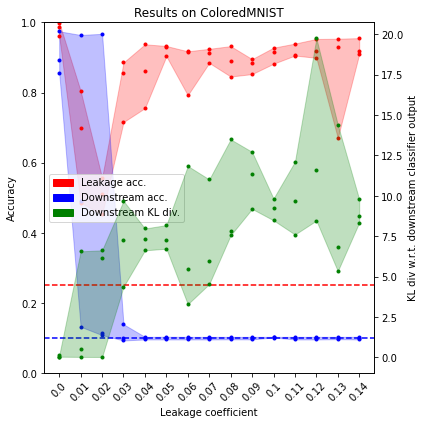

In [2]:
from matplotlib import patches, markers

fig_width = 6
fig, axes = plt.subplots(1, len(results), figsize=(fig_width*len(results), fig_width))
def compress(x, compress_fn, d=3):
    return np.array([
        compress_fn(x[d*idx:d*(idx+1)]) for idx in range(len(x)//d)
    ])
if not hasattr(axes, '__len__'):
    axes = np.array([axes])
for ax, (d_name, d_results) in zip(axes, results.items()):
    leakage_coefficients = d_results['gen_leakage_coefficients']
    leakage_accs = d_results['leakage_acc']
    downstream_accs = d_results['downstream_acc']
    downstream_is = np.log(d_results['downstream_inception_score'])
    xticks = sum([3*[i] for i in range(len(np.unique(leakage_coefficients)))], start=[])
    cxticks = [i for i in range(len(np.unique(leakage_coefficients)))]
    ax.plot(xticks, leakage_accs, '.', color='red')
    ax.plot(xticks, downstream_accs, '.', color='blue')
    ax.fill_between(cxticks, compress(leakage_accs, np.min), compress(leakage_accs, np.max), color='red', alpha=0.25)
    ax.fill_between(cxticks, compress(downstream_accs, np.min), compress(downstream_accs, np.max), color='blue', alpha=0.25)
    tax = ax.twinx()
    tax.plot(xticks, downstream_is, '.', color='green')
    tax.fill_between(cxticks, compress(downstream_is, np.min), compress(downstream_is, np.max), color='green', alpha=0.25)
    ax.axhline(0.25 if d_name == 'ColoredMNIST' else 0.5, linestyle='--', color='red')
    ax.axhline(0.1, linestyle='--', color='blue')
    ax.set_xlabel('Leakage coefficient')
    ax.set_ylabel('Accuracy')
    tax.set_ylabel('KL div w.r.t. downstream classifier output')
    ax.set_title('Results on {}'.format(d_name))
    ax.set_xticks(np.unique(xticks))
    ax.set_xticklabels(np.unique(leakage_coefficients), rotation=45)
    ax.set_ylim(0, 1)
    ax.legend(handles=[
        patches.Patch(color='red', label='Leakage acc.'),
        patches.Patch(color='blue', label='Downstream acc.'),
        patches.Patch(color='green', label='Downstream KL div.')
    ], loc='center left')
plt.tight_layout()